In [60]:
# Let's load values from the .env file
from dotenv import dotenv_values

config = dotenv_values()

# We also will need SQLAlchemy and its functions
from sqlalchemy import create_engine, types
from sqlalchemy.dialects.postgresql import JSON as postgres_json
from sqlalchemy import text # to be able to pass string

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# this so called "line magic" command, amongst other things, stores the plots in the notebook document.
%matplotlib inline

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import the statsmodels.api module
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

In [61]:
# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

#SQL access details
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)
engine.url # password is hidden
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {pg_schema};'))

In [66]:
with engine.begin() as conn: # Done with echo=False
    result = conn.execute(text(f'''
                               SELECT * FROM mart_song; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
df_song = pd.DataFrame(data) 

In [67]:
df_song['point_ratio'] = df_song['point_ratio'].astype('float')

# reordering columns 

df_song = df_song[['point_ratio', 'semi_final', 'semi_draw_position', 
        'final_draw_position','country', 'artist_name', 'song_name', 'language',
       'direct_qualifier_10', 'main_singers', 'loudness_db', 'beats_per_min',
       'energy', 'danceability', 'happiness', 'acousticness',
       'instrumentalness', 'liveness', 'speechiness', 'backing_dancers',
       'backing_singers', 'backing_instruments', 'instrument_10',
       'qualified_10', 'final_televote_points', 'final_jury_points',
       'final_televote_votes', 'final_jury_votes', 'semi_place', 'semi_televote_points',
       'semi_jury_points', 'semi_total_points', 'favourite_10', 'host_10',
        'key', 'style','gender','final_place','final_total_points']]

In [68]:
#removing NaN values for final place and making those who aren't in the final heavily weighted as doing poorly (i.e., below 26th)
df_song['final_place'] = df_song['final_place'].fillna(30)
filter = ((df_song['beats_per_min'].notnull()) & (df_song['energy'].notnull()) & (df_song['danceability'].notnull()) & 
          (df_song['happiness'].notnull()) & (df_song['acousticness'].notnull()) & (df_song['instrumentalness'].notnull()) 
          & (df_song['liveness'].notnull()) & (df_song['speechiness'].notnull()))
df_song = df_song[filter]
df_song = df_song.drop(['artist_name', 'song_name', 'loudness_db', 'semi_final', 'semi_draw_position', 
                                                'final_draw_position', 'direct_qualifier_10', 'final_televote_points','final_jury_points',
                                                'final_televote_votes','final_jury_votes','semi_place', 'semi_televote_points', 
                                                'semi_jury_points','semi_total_points', 'qualified_10', 'final_total_points'], axis='columns')

df_song.isna().sum()
df_song_all_numbers = pd.get_dummies(df_song, columns=['country', 'language','key', 'style','gender',], drop_first=True, dtype='int')

In [69]:
# Normalizing Data 

scaler = Normalizer()
scaler.fit(df_song_all_numbers) #(adjusting the scaler to our particular dataset, learning it)
df_scaled = scaler.transform(df_song_all_numbers) #(using the scaler to our particular data frame)
df_song_normalized = pd.DataFrame(df_scaled, columns=df_song_all_numbers.columns)

In [70]:
# standardizing data

scaler = StandardScaler()
scaler.fit(df_song_all_numbers) #(adjusting the scaler to our particular dataset, learning it)
df_scaled = scaler.transform(df_song_all_numbers) #(using the scaler to our particular data frame)
df_song_standardized = pd.DataFrame(df_scaled, columns=df_song_all_numbers.columns)

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

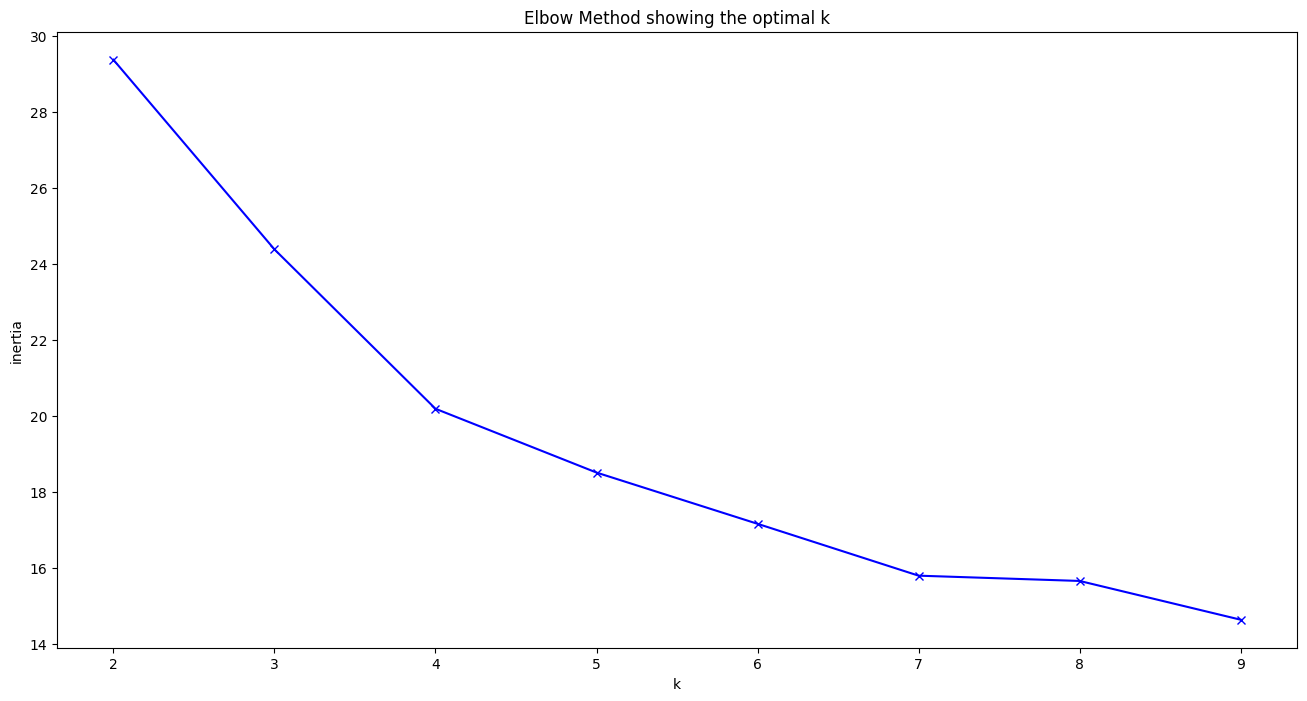

In [71]:
# calculating k for df_song_normalized

K = range(2, 10) #let's give it a range
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234) # a different random state
    kmeans.fit(df_song_normalized)
    inertia.append(kmeans.inertia_) #Inertia measures how well a dataset was clustered by K-Means

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-') # shows the x symbols on the graph
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method showing the optimal k')


For df_song_normalized k=4

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

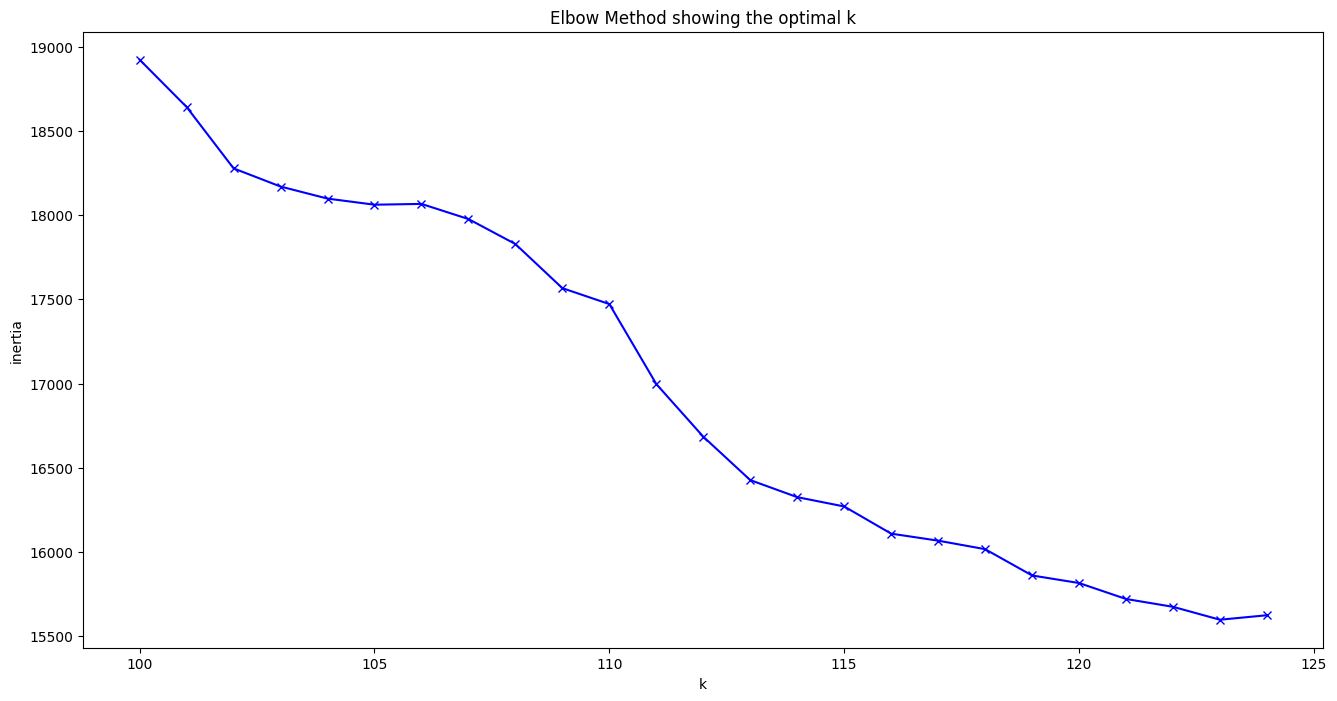

In [73]:
# calculating k for df_song_standardized

K = range(100, 125) #let's give it a range
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234) # a different random state
    kmeans.fit(df_song_standardized)
    inertia.append(kmeans.inertia_) #Inertia measures how well a dataset was clustered by K-Means

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-') # shows the x symbols on the graph
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method showing the optimal k')


For df_song_standardized k=113??

In [79]:
# Creating K-Means for df_song_normalized

kmeans = KMeans(n_clusters=4, random_state=47) #You can use any random_state of course
kmeans.fit(df_song_normalized)
#Since we do not know the amount of k that will be appropriate to our data, you want to use the same random state.
kmeans.inertia_

clusters = kmeans.predict(df_song_normalized)
pd.Series(clusters).value_counts().sort_index()
df_normalized_clustered = df_song_normalized.copy() 
df_normalized_clustered["cluster"] = clusters

0      3
1      2
2      0
3      0
4      2
      ..
465    1
466    1
467    2
468    0
469    2
Name: cluster, Length: 470, dtype: int32